In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy
import pandas as pd

import matplotlib.animation as animation
import IPython

import torch.distributions as tdist

from ipywidgets import interact

from utils import *
from variational_inference_classes import *

%load_ext autoreload
%autoreload 2

# Some Unit Tests

## Tests for $\gamma(\lambda, \beta)$
This is for (un-regularised) lower incomplete gamma function. 

Testing that as $\beta \to \infty$
$$
\frac{d}{d\lambda}\gamma(\lambda, \beta) \to \psi(\lambda)
$$

<p style="color:red;font-size:large">
    It seem like the following implementation only works for some range of $\lambda$, $\beta$ and becomes numerically unstable elsewhere.....
</p>

In [2]:
def gradgamma(lmbda, beta):
    # reference: Eq 25 for derivative of upper incomplete gamma in 
    # http://www.iaeng.org/IJAM/issues_v47/issue_3/IJAM_47_3_04.pdf
    acc = 0
    for k in range(50):
        term1 = torch.log(beta) / (lmbda + k)
        term1 -= 1 / (lmbda + k)**2
        
        logterm2 = (
            (k + lmbda) * torch.log(beta) - torch.lgamma(torch.tensor([k + 1], dtype=torch.float))
        )
        term2 = torch.exp(logterm2)
        if k % 2 == 1:
            term2 *= -1
        acc += term1 * term2
        
#         print(f"{k:3d}, {term1.item():.5f}, {term2.item():.5f}, {acc.item():.5f}, {(term1 * term2).item():.5f}")
    return acc

def _integrand(t, lmbda, beta, n):
    return np.exp(-beta * t) * (beta * t)**(lmbda-1) * np.log(beta * t)**n

def _integrated1(lmbda, beta):
    return scipy.integrate.quad(_integrand, 0, 1, args=(lmbda, beta, 1))[0] * beta

_vec_integrated = np.vectorize(_integrated1)

def gradgamma_int(lmbda, beta):
    return torch.tensor(_vec_integrated(lmbda, beta))



lmbda = torch.tensor([.5, .5, 1., 1., 2., 2., 10., 10.])
beta = torch.tensor([5., 10., 5., 10., 5., 10., 5., 10.])
print(torch.digamma(lmbda))
x = gradgamma(lmbda, beta)
y = gradgamma_int(lmbda, beta)
print(x.tolist())
print(y.tolist())
print((x - y).tolist())

tensor([-1.9635, -1.9635, -0.5772, -0.5772,  0.4228,  0.4228,  2.2518,  2.2518])
[-3.485140562057495, -3.481759786605835, -0.589206874370575, -0.581569254398346, 0.3498516082763672, 0.40837812423706055, 16756.193359375, 4392482.0]
[-3.485140035535015, -3.480263722174373, -0.589208267845169, -0.5773243590717142, 0.34983224839485394, 0.42158486898258063, 16734.905289061047, 396770.57728189195]
[-5.265224802819546e-07, -0.0014960644314618854, 1.3934745940469284e-06, -0.004244895326631748, 1.9359881513247856e-05, -0.013206744745520083, 21.28807031395263, 3995711.422718108]


/Users/elau1/.local/share/virtualenvs/variational-approximation-for-singular-mod-zs1nWu9R/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/Users/elau1/.local/share/virtualenvs/variational-approximation-for-singular-mod-zs1nWu9R/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'd

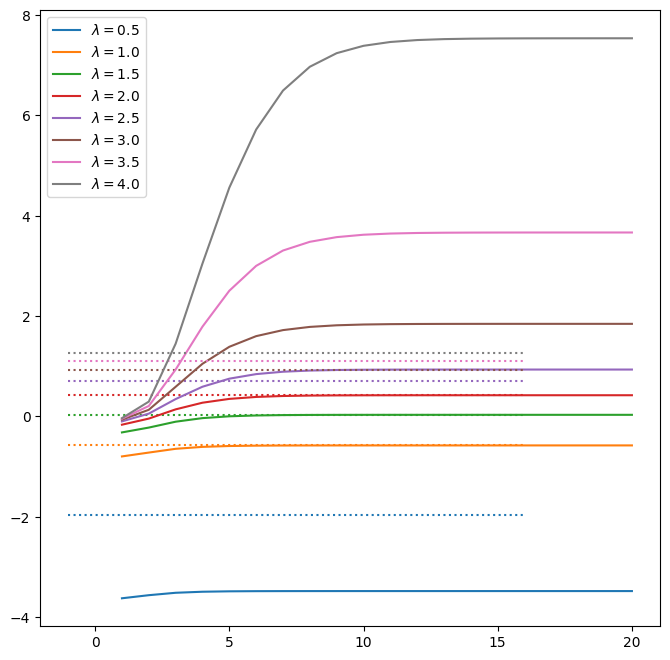

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
bs = torch.linspace(1, 20, steps=20)
for lmbda in [.5, 1., 1.5, 2.0, 2.5, 3.0, 3.5, 4.]:
    lmbda = torch.tensor([lmbda], dtype=torch.float)
    y = [gradgamma_int(lmbda, b) for b in bs]
    p = ax.plot(bs, y, label=f"$\\lambda={lmbda.item()}$")
    xmin, xmax = -1, 16
    ax.hlines([torch.digamma(lmbda).numpy()], xmin, xmax, linestyle="dotted", color=p[0].get_color())
    ax.legend()

## Unit test asymptotic approximation to `elbo_func_mf_gamma_trunc`



In [4]:
igamma = torch.igamma
gradigamma = GradLambdaRegularisedLowerIncompleteGamma.apply # lambda x, y: torch.digamma(x) #
def elbo_func_mf_gamma_trunc(lambdas, ks, betas, lambda_0, k_0, n, ignore_term=True):
    r = k_0 / ks
    iglambdas_betas = igamma(lambdas, betas)
    logbetas = torch.log(betas)
    term1 = n * torch.exp(torch.sum(
        -r * logbetas
        + torch.lgamma(lambdas + r) - torch.lgamma(lambdas)
        + torch.log(igamma(lambdas + r, betas)) - torch.log(iglambdas_betas)
    ))

    term2 = torch.sum(
        torch.log(2 * ks) + lambdas * logbetas 
        - torch.lgamma(lambdas) - torch.log(iglambdas_betas)
        - lambdas * (igamma(lambdas + 1, betas) / iglambdas_betas)
    )
    # this term is the problematic term that involves derivatives of incomplete gamma function. 
    # when lambdas and ks matches the true parameters, this should be zero, 
    # but even there, it would generically has non-zero gradient. 
    if not ignore_term:
        term2 += (lambdas - r * lambda_0) * (gradigamma(lambdas, betas) / iglambdas_betas - logbetas)
    return -term1 - term2

def elbo_func_well_specified(betas, lambda_0, k_0, n):
    lambdas = lambda_0
    ks = k_0
    iglambdas_betas = torch.igamma(lambdas, betas)
    logbetas = torch.log(betas)
    r = 1
    term1 = n * torch.exp(torch.sum(
        -r * logbetas
        + torch.lgamma(lambdas + r) - torch.lgamma(lambdas)
        + torch.log(igamma(lambdas + r, betas)) - torch.log(iglambdas_betas)
    ))

    term2 = torch.sum(
        torch.log(2 * ks) + lambdas * logbetas 
        - torch.lgamma(lambdas) - torch.log(iglambdas_betas)
        - lambdas * (igamma(lambdas + 1, betas) / iglambdas_betas)
    )
    return -term1 - term2


def test_elbo_fn(betas, lambda_0, k_0, n):
    rlct = torch.min(lambda_0)
    assert rlct == lambda_0[0]
    l02 = lambda_0[1]
    
    G = l02 / betas[1] * torch.igamma(l02 + 1, betas[1]) / torch.igamma(l02, betas[1])
    logB = (
        -l02 * torch.log(betas[1]) 
        + torch.lgamma(l02)
        + torch.log(torch.igamma(l02,betas[1])) 
        - torch.log(2 * k_0[1])
    )
    correction1 = torch.lgamma(rlct) - torch.log(2 * k_0[0])
    return rlct * (-torch.log(betas[0]) + 1 - G) + betas[1]*G + logB + correction1


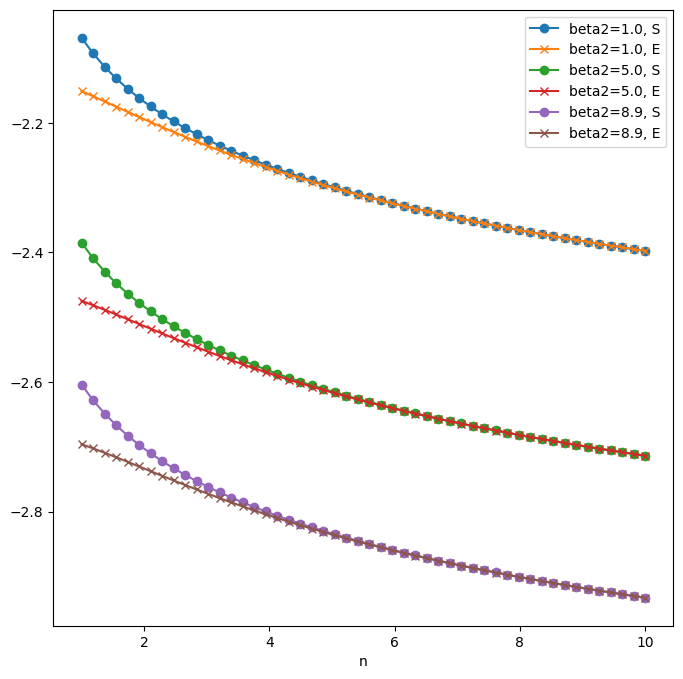

In [5]:

k_0 = torch.tensor([7., 5.])  # assume no "flat" dimensions with k_j = 0
h_0 = torch.tensor([1., 3.])
# k_0 = torch.tensor([3., 3.])  # assume no "flat" dimensions with k_j = 0
# h_0 = torch.tensor([3., 3.])
lambda_0 = (h_0 + 1) / (2 * k_0)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for beta2 in [1.0, 5.0, 8.9]:
    ns = []
    ts = []
    vs = []
    for n in np.linspace(1, 10, num=50):
#     for logn in range(1, 12):
#         n = 10**logn
        betas = torch.tensor([n, beta2])
        t = test_elbo_fn(betas, lambda_0, k_0, n)
        v = elbo_func_well_specified(betas, lambda_0, k_0, n)
        ns.append(n)
        ts.append(t)
        vs.append(v)
    ax.plot(ns, ts, "o-", label=f"beta2={beta2}, S")
    ax.plot(ns, vs, "x-", label=f"beta2={beta2}, E")
#     ax.set_xscale('log')
    ax.legend()
    ax.set_xlabel("n")

# Misc

In [20]:
f = lambda y, x: gaussian_on_standard_form.true_unnormalised_density(torch.tensor([x, y]))
scipy.integrate.dblquad(f, 0, 1, 0, 1)

(0.060759627300232134, 1.284435631123736e-08)

In [21]:

class CustomsFunc(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, y):
        ctx.save_for_backward(x, y)
        return x**2 + 13 * y
    
    @staticmethod
    def backward(ctx, grad_output):
        x, y = ctx.saved_tensors
        return grad_output * 2 * x, grad_output * 13


In [22]:
f = CustomsFunc.apply
x = torch.tensor(3., requires_grad=True)
y = torch.tensor(4., requires_grad=True)
z = f(x, y)
z.backward()

x.grad, y.grad

(tensor(6.), tensor(13.))

In [23]:
x = torch.tensor(3., requires_grad=True)
y = torch.tensor(10., requires_grad=True)
z = igamma(x, y)
z.backward()
x.grad, y.grad

(tensor(-0.4614), tensor(0.2270))

In [24]:
@interact(
    n=(2, 10000), 
    t=(-2.0, 2.0)
)
def _plot_contour(n=50, t=0.5):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    x = np.linspace(-1, 1, num=1000)
    ax.plot(x, np.cos(2 * np.pi * n * (x**4 + t * x)) * (1 - np.exp(-1/x**2)), alpha=0.8)
    ax.plot(x, (1 - np.exp(-1/x**2)), color="r", alpha=0.5)
    ax.plot(x, -(1 - np.exp(-1/x**2)), color="r", alpha=0.5)

interactive(children=(IntSlider(value=50, description='n', max=10000, min=2), FloatSlider(value=0.5, descripti…

In [25]:
x1 = torch.tensor([1.0], requires_grad=False)
x2 = torch.tensor([2.0], requires_grad=True)

optim = torch.optim.Adam([x1, x2], lr=0.1)
for _ in range(10):
    optim.zero_grad()
    x = torch.stack([x1, x2], dim=-1)
#     a = x1**2 + x2**2
    a = torch.sum(x**2)
    a.backward()
    optim.step()
    print(a, x1, x2)

tensor(5., grad_fn=<SumBackward0>) tensor([1.]) tensor([1.9000], requires_grad=True)
tensor(4.6100, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.8002], requires_grad=True)
tensor(4.2406, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.7006], requires_grad=True)
tensor(3.8921, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.6015], requires_grad=True)
tensor(3.5648, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.5030], requires_grad=True)
tensor(3.2589, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.4051], requires_grad=True)
tensor(2.9744, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.3082], requires_grad=True)
tensor(2.7114, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.2123], requires_grad=True)
tensor(2.4698, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.1177], requires_grad=True)
tensor(2.2493, grad_fn=<SumBackward0>) tensor([1.]) tensor([1.0246], requires_grad=True)


In [26]:

x1 = torch.tensor([10.000, 2.0, 3.2])
y1 = torch.tensor([6., 2.0, 1.0])
%time grad_lmbda_lower_incomplete_gamma(x1, y1)

CPU times: user 693 µs, sys: 5 µs, total: 698 µs
Wall time: 382 µs


tensor([0., 0., 0.])

In [27]:
x = x1.numpy()
y = y1.numpy()
def integrand(t, x, y):
    return np.exp(-y * t) * (y * t)**(x-1) * np.log(y * t)
# integrand = lambda t, x, y: np.exp(-y * t) * (y * t)**(x-1) * np.log(y * t)

def f(x, y):
    return scipy.integrate.quad(integrand, 0, 1, args=(x, y))[0] * y

fvec = np.vectorize(f)
# vec_integrand = np.vectorize(integrand)
# %time scipy.integrate.quad(integrand, 0, 1)
%time fvec(x1, y1)

CPU times: user 879 µs, sys: 7 µs, total: 886 µs
Wall time: 890 µs


array([ 4.91165965e+04, -4.28732689e-02, -5.58167725e-02])

In [28]:
grad_lmbda_lower_incomplete_gamma(x1, y1)

tensor([0., 0., 0.])

In [3]:
lmbda = torch.tensor([0.5, 1.5, 2.0, 3.2, 5.0])
beta = torch.tensor([4.5, 1.0, 23.1, 5.0, 2.3])

epsilon = 1e-3
D1_ORD6_STENCIL = torch.tensor([-1.0/60, 3.0/20, -3.0/4, 0.0, 3.0/4, -3.0/20, 1.0/60])
D2_ORD6_STENCIL = torch.tensor([1.0/90, -3.0/20, 3.0/2, -49.0/18, 3.0/2, -3.0/20, 1.0/90])

xs = x0 + torch.arange(-3, 4, step=1, dtype=torch.float) * epsilon
torch.sum(torch.igamma(xs, beta) * D1_ORD6_STENCIL) / epsilon

NameError: name 'x0' is not defined

In [59]:
print(lmbda)
print(beta)

tensor([0.5000, 1.5000, 2.0000, 3.2000, 5.0000])
tensor([ 4.5000,  1.0000, 23.1000,  5.0000,  2.3000])


In [56]:
n = lmbda.shape[0]

deltas = torch.arange(-3, 4, step=1, dtype=torch.float) * epsilon
xs = deltas.repeat((n, 1)).T + lmbda
xs

tensor([[0.4970, 1.4970, 1.9970, 3.1970, 4.9970],
        [0.4980, 1.4980, 1.9980, 3.1980, 4.9980],
        [0.4990, 1.4990, 1.9990, 3.1990, 4.9990],
        [0.5000, 1.5000, 2.0000, 3.2000, 5.0000],
        [0.5010, 1.5010, 2.0010, 3.2010, 5.0010],
        [0.5020, 1.5020, 2.0020, 3.2020, 5.0020],
        [0.5030, 1.5030, 2.0030, 3.2030, 5.0030]])

In [69]:
x = torch.arange(-3, 4, step=1, dtype=torch.float)
x.repeat((3, 1))

tensor([[-3., -2., -1.,  0.,  1.,  2.,  3.],
        [-3., -2., -1.,  0.,  1.,  2.,  3.],
        [-3., -2., -1.,  0.,  1.,  2.,  3.]])

In [64]:
torch.sum(torch.igamma(xs, beta).T * D1_ORD6_STENCIL / epsilon, axis=1)

tensor([-0.0098, -0.3748,  0.0000, -0.1252, -0.0799])